<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#H2O-API-Walkthrough" data-toc-modified-id="H2O-API-Walkthrough-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>H2O API Walkthrough</a></span><ul class="toc-item"><li><span><a href="#General-Setup" data-toc-modified-id="General-Setup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>General Setup</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

%watermark -a 'Ethen' -d -t -v -p h2o,matplotlib

Ethen 2018-05-03 12:08:03 

CPython 3.6.4
IPython 6.3.1

h2o 3.18.0.4
matplotlib 2.2.2


# H2O API Walkthrough

## General Setup

The first question you might be asking is why H2O instead of scikit-learn or Spark MLlib.

- People would prefer H2O over scikit-learn because it is much straightforward to integrate ML models into an existing non-Python system, i.e., Java-based product.
- Performance wise, H2O is extremely fast and can outperform scikit-learn by a significant amount when the data size we're dealing with large datset. As for Spark, while it is a decent tool for ETL on raw data (which often is indeed "big"), its ML libraries are often times outperformed (in training time, memory footprint and even accuracy) by much better tools by orders of magnitude. Please refer to the benchmark at the following link for more detailed number-based proofs. [Github: A minimal benchmark for scalability, speed and accuracy of commonly used open source implementations](https://github.com/szilard/benchm-ml)

```bash
# for installing h2o in python
pip install h2o
```

In [3]:
# Load the H2O library and start up the H2O cluter locally on your machine
import h2o

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_161"; Java(TM) SE Runtime Environment (build 1.8.0_161-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.161-b12, mixed mode)
  Starting server from /Users/mingyuliu/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/b6/fy5cl70s7nq6g7275rkdpd6m3967fj/T/tmpkx3ild87
  JVM stdout: /var/folders/b6/fy5cl70s7nq6g7275rkdpd6m3967fj/T/tmpkx3ild87/h2o_mingyuliu_started_from_python.out
  JVM stderr: /var/folders/b6/fy5cl70s7nq6g7275rkdpd6m3967fj/T/tmpkx3ild87/h2o_mingyuliu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.4
H2O cluster version age:,1 month and 24 days
H2O cluster name:,H2O_from_python_mingyuliu_hxtmy3
H2O cluster total nodes:,1
H2O cluster free memory:,7.111 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In this example, we will be working with a cleaned up version of the Lending Club Bad Loans dataset. The purpose here is to predict whether a loan will be bad (i.e. not repaid to the lender). The response column, `bad_loan`, is 1 if the loan was bad, and 0 otherwise.

In [4]:
filepath = 'https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv'
data = h2o.import_file(filepath)
print('dimension:', data.shape)
data.head(6)

Parse progress: |█████████████████████████████████████████████████████████| 100%
dimension: (163987, 15)


loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
5000,36 months,10.65,10,RENT,24000,credit_card,AZ,27.65,0,83.7,9,0,26,verified
2500,60 months,15.27,0,RENT,30000,car,GA,1,0,9.4,4,1,12,verified
2400,36 months,15.96,10,RENT,12252,small_business,IL,8.72,0,98.5,10,0,10,not verified
10000,36 months,13.49,10,RENT,49200,other,CA,20,0,21,37,0,15,verified
5000,36 months,7.9,3,RENT,36000,wedding,AZ,11.2,0,28.3,12,0,7,verified
3000,36 months,18.64,9,RENT,48000,car,CA,5.35,0,87.5,4,0,4,verified


Since the task we're dealing at hand is a binary classification problem, we must ensure that our response variable is encoded as a `factor` type. If the response is represented as numerical values of 0/1, H2O will assume we want to train a regression model.

In [5]:
# encode the binary repsonse as a factor
label_col = 'bad_loan'
data[label_col] = data[label_col].asfactor()

# this is an optional step that checks the factor level
data[label_col].levels()

[['0', '1']]

In [6]:
# if we check types of each column, we can see which columns
# are treated as categorical type (listed as 'enum')
data.types

{'loan_amnt': 'int',
 'term': 'enum',
 'int_rate': 'real',
 'emp_length': 'int',
 'home_ownership': 'enum',
 'annual_inc': 'real',
 'purpose': 'enum',
 'addr_state': 'enum',
 'dti': 'real',
 'delinq_2yrs': 'int',
 'revol_util': 'real',
 'total_acc': 'int',
 'bad_loan': 'enum',
 'longest_credit_length': 'int',
 'verification_status': 'enum'}

Next, we perform a three-way split:

- 70% for training
- 15% for validation
- 15% for final testing

We will train a data set on one set and use the others to test the validity of the model by ensuring that it can predict accurately on data the model has not been shown. i.e. to ensure our model is generalizable.

In [7]:
# 1. for the splitting percentage, we can leave off
# the last proportion, and h2o will generate the
# number for the last subset for us
# 2. setting a seed will guarantee reproducibility
random_split_seed = 1234
train, valid, test = data.split_frame([0.7, 0.15], seed = random_split_seed)
print(train.nrow)
print(valid.nrow)
print(test.nrow)

114910
24503
24574


Here, we extract the column name that will serve as our response and predictors. These informations will be used during the model training phase.

In [8]:
# .names, .col_names, .columns are
# all equivalent way of accessing the list
# of column names for the h2o dataframe
input_cols = data.columns

# remove the response and the interest rate
# column since it's correlated with our response
input_cols.remove(label_col)
input_cols.remove('int_rate')
input_cols

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

## Modeling

We'll now jump into the model training part, here Gradient Boosted Machine (GBM) is used as an example. We will set the number of trees to be 500. Increasing the number of trees in a ensemble tree-based model like GBM is one way to increase performance of the model, however, we have to be careful not to overfit our model to the training data by using too many trees. To automatically find the optimal number of trees, we can leverage H2O's early stopping functionality.

There are several parameters that could be used to control early stopping. The three that are generic to all the algorithms are: `stopping_rounds`, `stopping_metric` and `stopping_tolerance`.

- `stopping metric` is the metric by which we'd like to measure performance, and we will choose `AUC` here.
- `score_tree_interval` is a parameter specific to tree-based models. e.g. setting score_tree_interval=5 will score the model after every five trees.

The parameters we have specify below is saying that our model will stop training after there have been three scoring intervals where the AUC has not increased more than 0.0005. Since we have specified a validation frame, the stopping tolerance will be computed on validation AUC rather than training AUC.

In [9]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator


# we specify an id for the model so we can refer to it more
# easily later
gbm = H2OGradientBoostingEstimator(
    seed = 1,
    ntrees = 500,
    model_id = 'gbm1',
    stopping_rounds = 3,
    stopping_metric = 'auc',
    score_tree_interval = 5,
    stopping_tolerance = 0.0005)

# note that it is .train not .fit to train the model
# just in case you're coming from scikit-learn
gbm.train(
    y = label_col,
    x = input_cols,
    training_frame = train,
    validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [10]:
# evaluating the performance, printing the whole
# model performance object will give us a whole bunch
# of information, we'll only be accessing the auc metric here
gbm_test_performance = gbm.model_performance(test)
gbm_test_performance.auc()

0.6794802299346006

To examine the scoring history, use the `scoring_history` method on a trained model. When early stopping is used, we see that training stopped at before the full 500 trees. Since we also used a validation set in our model, both training and validation performance metrics are stored in the scoring history object. We can take a look at the validation AUC to observe that the correct stopping tolerance was enforced.

In [11]:
gbm_history = gbm.scoring_history()
gbm_history

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
0,,2018-05-03 12:08:13,0.077 sec,0.0,0.386713,0.475996,0.500000,1.000000,0.816944,0.386364,0.475360,0.500000,1.000000,0.817369
1,,2018-05-03 12:08:14,1.061 sec,5.0,0.379493,0.458513,0.673333,2.945489,0.327883,0.379732,0.459108,0.668517,2.496842,0.353018
2,,2018-05-03 12:08:15,1.757 sec,10.0,0.376101,0.450690,0.681477,3.101920,0.352067,0.376950,0.452440,0.674121,2.626474,0.376280
3,,2018-05-03 12:08:15,2.048 sec,15.0,0.373994,0.445856,0.689024,3.239678,0.342581,0.375470,0.448767,0.679275,2.648732,0.348855
4,,2018-05-03 12:08:16,2.349 sec,20.0,0.372506,0.442351,0.695708,3.315682,0.322148,0.374558,0.446444,0.682624,2.670991,0.373056
5,,2018-05-03 12:08:16,2.624 sec,25.0,0.371359,0.439697,0.700413,3.372685,0.311104,0.373916,0.444788,0.685287,2.670991,0.344611
6,,2018-05-03 12:08:16,2.850 sec,30.0,0.370526,0.437717,0.704236,3.448689,0.302672,0.373476,0.443659,0.686976,2.760024,0.353589
7,,2018-05-03 12:08:16,3.075 sec,35.0,0.369722,0.435857,0.707691,3.505693,0.285798,0.373115,0.442722,0.688511,2.804540,0.349916
8,,2018-05-03 12:08:17,3.304 sec,40.0,0.369036,0.434259,0.710893,3.538944,0.287912,0.372897,0.442141,0.689310,2.760024,0.309554
9,,2018-05-03 12:08:17,3.536 sec,45.0,0.368417,0.432869,0.713505,3.624449,0.286920,0.372789,0.441811,0.689636,2.782282,0.345550


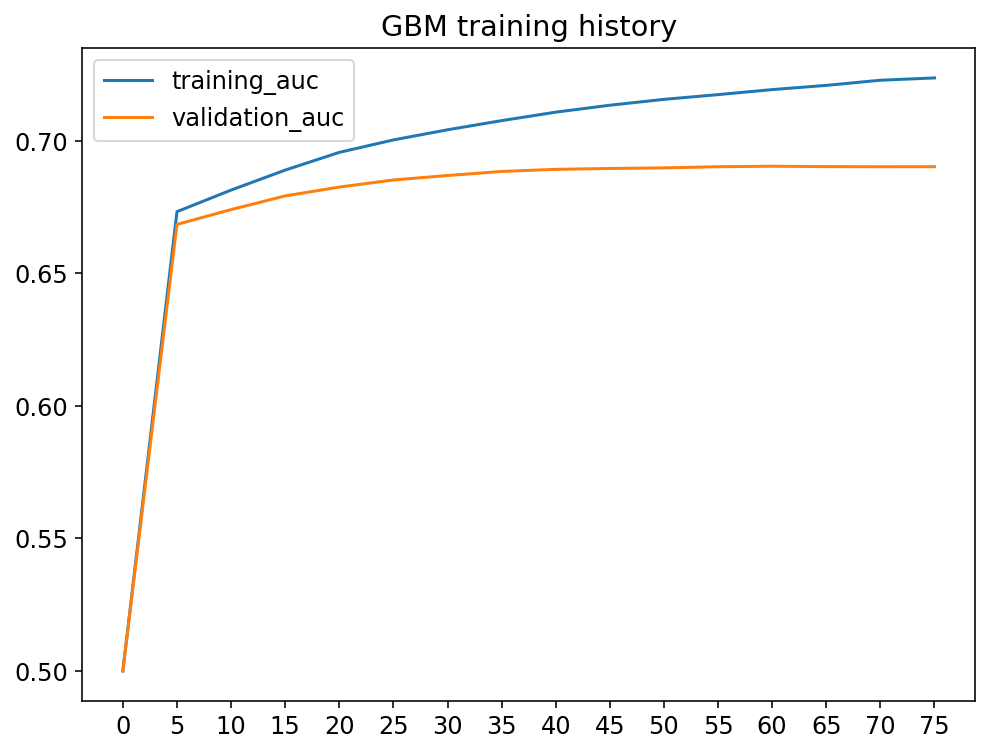

In [12]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(gbm_history['training_auc'], label = 'training_auc')
plt.plot(gbm_history['validation_auc'], label = 'validation_auc')
plt.xticks(range(gbm_history.shape[0]), gbm_history['number_of_trees'].apply(int))
plt.title('GBM training history')
plt.legend()
plt.show()

## Hyperparameter Tuning

When training machine learning algorithm, often times we wish to perform hyperparameter search. Thus rather than training our model with different parameters manually one-by-one, we will make use of the H2O's Grid Search functionality. H2O offers two types of grid search -- `Cartesian` and `RandomDiscrete`.  Cartesian is the traditional, exhaustive, grid search over all the combinations of model parameters in the grid, whereas Random Grid Search will sample sets of model parameters randomly for some specified period of time (or maximum number of models).

In [13]:
# specify the grid
gbm_params = {
    'max_depth': [3, 5, 9],
    'sample_rate': [0.8, 1.0],
    'col_sample_rate': [0.2, 0.5, 1.0]}

If we wish to specify model parameters that are not part of our grid, we pass them along to the grid via the `H2OGridSearch.train()` method. See example below.

In [14]:
from h2o.grid.grid_search import H2OGridSearch


gbm_tuned = H2OGridSearch(
    grid_id = 'gbm_tuned1',
    hyper_params = gbm_params,
    model = H2OGradientBoostingEstimator)
gbm_tuned.train(
    y = label_col,
    x = input_cols,
    training_frame = train,
    validation_frame = valid,
    # nfolds = 5,  # alternatively, we can use N-fold cross-validation
    ntrees = 100,
    stopping_rounds = 3,
    stopping_metric = 'auc',
    score_tree_interval = 5,
    stopping_tolerance = 0.0005)  # we can specify other parameters like early stopping here

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


To compare the model performance among all the models in a grid, sorted by a particular metric (e.g. AUC), we can use the `get_grid` method.

In [15]:
gbm_tuned = gbm_tuned.get_grid(
    sort_by = 'auc', decreasing = True)
gbm_tuned

     col_sample_rate max_depth sample_rate            model_ids  \
0                0.5         3         0.8   gbm_tuned1_model_1   
1                0.5         3         1.0  gbm_tuned1_model_10   
2                0.5         5         1.0  gbm_tuned1_model_13   
3                0.2         5         1.0  gbm_tuned1_model_12   
4                0.2         5         0.8   gbm_tuned1_model_3   
5                1.0         3         1.0  gbm_tuned1_model_11   
6                0.2         3         0.8   gbm_tuned1_model_0   
7                1.0         5         1.0  gbm_tuned1_model_14   
8                0.5         5         0.8   gbm_tuned1_model_4   
9                1.0         3         0.8   gbm_tuned1_model_2   
10               1.0         5         0.8   gbm_tuned1_model_5   
11               0.2         3         1.0   gbm_tuned1_model_9   
12               0.2         9         1.0  gbm_tuned1_model_15   
13               0.2         9         0.8   gbm_tuned1_model_

Instead of running a grid search, the example below shows the code modification needed to run a random search.

In addition to the hyperparameter dictionary, we will need specify the `search_criteria` as `RandomDiscrete'` with a number for `max_models`, which is equivalent to the number of iterations to run for the random search. This example is set to run fairly quickly, we can increase `max_models` to cover more of the hyperparameter space.  Also, we can expand the hyperparameter space of each of the algorithms by modifying the hyperparameter list below.

In [16]:
# specify the grid and search criteria
gbm_params = {
    'max_depth': [3, 5, 9],
    'sample_rate': [0.8, 1.0],
    'col_sample_rate': [0.2, 0.5, 1.0]}

# note that in addition to max_models
# we can specify max_runtime_secs
# to run as many model as we can
# for X amount of seconds
search_criteria = {
    'max_models': 5,
    'strategy': 'RandomDiscrete'}

# train the hyperparameter searched model
gbm_tuned = H2OGridSearch(
    grid_id = 'gbm_tuned2',
    hyper_params = gbm_params,
    search_criteria = search_criteria,
    model = H2OGradientBoostingEstimator)
gbm_tuned.train(
    y = label_col,
    x = input_cols,
    training_frame = train,
    validation_frame = valid,
    ntrees = 100)

# evaluate the model performance
gbm_tuned = gbm_tuned.get_grid(
    sort_by = 'auc', decreasing = True)
gbm_tuned

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
    col_sample_rate max_depth sample_rate           model_ids  \
0               0.5         5         1.0  gbm_tuned2_model_1   
1               1.0         3         1.0  gbm_tuned2_model_2   
2               1.0         5         0.8  gbm_tuned2_model_0   
3               0.2         9         0.8  gbm_tuned2_model_3   
4               1.0         9         1.0  gbm_tuned2_model_4   

                  auc  
0  0.6914196605199648  
1  0.6905814596994375  
2  0.6895219932318218  
3  0.6848488373260676  
4  0.6788494710756896  


Lastly, let's extract the top model, as determined by validation AUC, from the grid and use to evaluate the model performance on a test set, so we get an honest estimate of top model performance.

In [17]:
# our model is reordered based on the sorting done above;
# hence we can retrieve the first model id to retrieve
# to best performing model that we currently have
gbm_best = gbm_tuned.models[0]
gbm_best_performance = gbm_best.model_performance(test)
gbm_best_performance.auc()

0.6797920802073659

In [18]:
# saving and loading the model
model_path = h2o.save_model(
    model = gbm_best, path = 'h2o_gbm', force = True)
saved_model = h2o.load_model(model_path)
gbm_best_performance = saved_model.model_performance(test)
gbm_best_performance.auc()

0.6797920802073659

In [19]:
# generate the prediction on the test set, notice that
# it will generate the predicted probability
# along with the actual predicted class;
#
# we can extract the predicted probability for the
# positive class and dump it back to pandas using
# the syntax below if necessary:
#
# gbm_test_pred['p1'].as_data_frame(use_pandas = True)
gbm_test_pred = gbm_best.predict(test)
gbm_test_pred

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
0,0.841312,0.158688
0,0.910571,0.089429
1,0.772623,0.227377
0,0.839826,0.160174
0,0.903449,0.0965509
0,0.809033,0.190967
0,0.821883,0.178117
0,0.852599,0.147401
0,0.881238,0.118762
0,0.864529,0.135471


In [20]:
# remember to shut down the h2o cluster once we're done
h2o.cluster().shutdown(prompt = False)

H2O session _sid_bdfa closed.


# Reference

- [H2O Sphinx Documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)
- [H2O Web Page Documentation](http://docs.h2o.ai/)
- [Quora: Why would one use H2O.ai over scikit-learn machine learning tool?](https://www.quora.com/Why-would-one-use-H2O-ai-over-scikit-learn-machine-learning-tool)
- [Github: Tutorials and training material for the H2O Machine Learning Platform](https://github.com/h2oai/h2o-tutorials)
- [Github: A minimal benchmark for scalability, speed and accuracy of commonly used open source implementations](https://github.com/szilard/benchm-ml)